In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [4]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.shape

(6362620, 11)

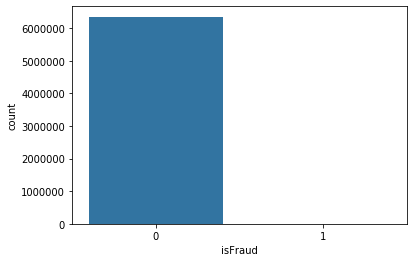

In [7]:
### distribution of fradulent transaction
sns.countplot(df.isFraud)

In [8]:
print('Percentage of fradulent transactions is {}%'.format(sum(df.isFraud)/len(df)*100))

Percentage of fradulent transactions is 0.12908204481801522%


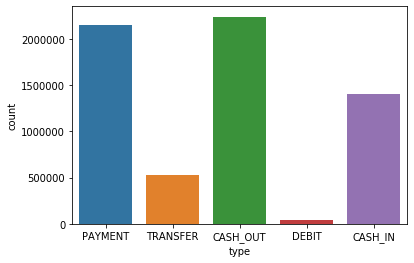

In [9]:
# type of payments
sns.countplot(df.type)

In [10]:
print('The types of fraudulent transactions are {}'.format(list(np.unique(df[df['isFraud'] == 1]['type']))))

The types of fraudulent transactions are ['CASH_OUT', 'TRANSFER']


In [11]:
### number of 'Cash out' payment and 'transfer' fraud payment
print('The number of fraudulent TRANSFERs is {}'.format(len(df[(df['type'] == 'TRANSFER')&(df['isFraud'] == 1)])))
print('The number of cash out TRANSFERs is {}'.format(len(df[(df['type'] == 'CASH_OUT')&(df['isFraud'] == 1)])))

The number of fraudulent TRANSFERs is 4097
The number of cash out TRANSFERs is 4116


In [12]:
### the variable isFlaggedFraud is vaguely described, we need more explore of it. It has been said that isFlaggedFraud
### will be labeled 1 if the transaction amount is larger than 200,000
len(df[df['isFlaggedFraud']==1])

16

In [13]:
### only 16 records
print('Type of transactions is 1 in isFlaggedFraud are {}'.format(list(np.unique(df[df['isFlaggedFraud']==1]['type']))))
print('Minimal transactions that is labeled as isFlaggedFraud = {}'.format(min(df[df['isFlaggedFraud']==1]['amount'])))
print('Maximal transactions that is labeled as isFlaggedFraud = {}'.format(max(df[df['isFlaggedFraud']==1]['amount'])))


Type of transactions is 1 in isFlaggedFraud are ['TRANSFER']
Minimal transactions that is labeled as isFlaggedFraud = 353874.22
Maximal transactions that is labeled as isFlaggedFraud = 10000000.0


In [14]:
### how about the records are not labeled 1 in isFlaggedFraud
print('Minimal transactions that is labeled as isFlaggedFraud = {}'.format(min(df[df['isFlaggedFraud']==0]['amount'])))
print('Maximal transactions that is labeled as isFlaggedFraud = {}'.format(max(df[df['isFlaggedFraud']==0]['amount'])))


Minimal transactions that is labeled as isFlaggedFraud = 0.0
Maximal transactions that is labeled as isFlaggedFraud = 92445516.64


In [15]:
### seem like the standard used to tell whether isFlaggedFraud or not is not consistent with what we have been told
### in the data description, so there must be some other factors

In [16]:
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [17]:
### data cleaning
X = df.loc[(df.type == 'TRANSFER')|(df.type == 'CASH_OUT')]
Y = X['isFraud']
del X['isFraud']

X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89


In [18]:
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [19]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

print("The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 \
although the transacted amount \nis non-zero is: {}".
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & (Xfraud.newBalanceDest == 0)]) / (len(Xfraud))))

print("\nThe fraction of genuine transactions with 'oldBalanceDest' = \
'newBalanceDest' = 0 although the transacted amount is \nnon-zero is: {}".\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))

The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted amount 
is non-zero is: 0.49628637525873615

The fraction of genuine transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted amount is 
non-zero is: 0.0006176245277308345


In [20]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


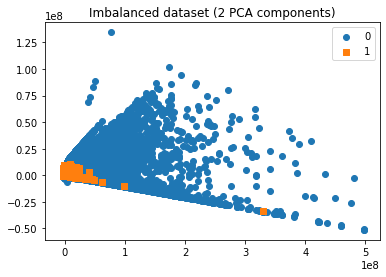

In [21]:
### scatter plot of the distribution of fraud and genuine transaction
# we will use pca to shrink the multi-dimentional data into 2 dimentions.

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

def plot_2d_space(X, Y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(Y), colors, markers):
        plt.scatter(
            X[Y==l, 0],
            X[Y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
    

plot_2d_space(X_pca, Y, 'Imbalanced dataset (2 PCA components)')

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [24]:
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.49      0.44      0.47      1646

    accuracy                           1.00    554082
   macro avg       0.75      0.72      0.73    554082
weighted avg       1.00      1.00      1.00    554082



<Figure size 432x288 with 0 Axes>

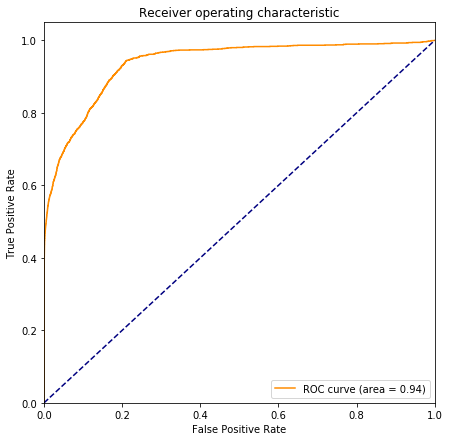

In [25]:
# Compute ROC curve and ROC area

fpr,tpr,threshold = roc_curve(y_test, log.predict_proba(X_test)[:,1]) 
roc_auc = auc(fpr,tpr)
 
plt.figure()
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

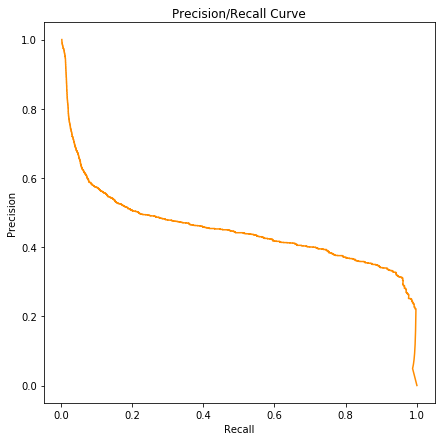

In [26]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, log.predict_proba(X_test)[:,1])
plt.figure(figsize=(7,7))
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(precision, recall,color='darkorange')
plt.show()


In [27]:
### recall is what we really care about but we have 0.44 recall in logistic model

In [28]:
from imblearn.over_sampling import SMOTE

os = SMOTE(sampling_strategy = 'minority', random_state = 0, )
X_train_os, y_train_os = os.fit_sample(X_train, y_train)

Using TensorFlow backend.


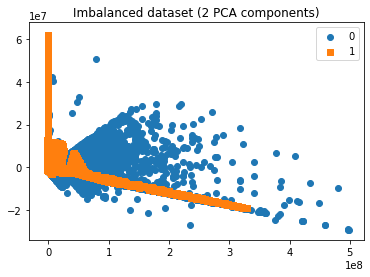

In [29]:
X_pca = pca.fit_transform(X_train_os)

plot_2d_space(X_pca, y_train_os, 'Imbalanced dataset (2 PCA components)')

In [30]:
log = LogisticRegression()
log.fit(X_train_os, y_train_os)
y_pred = log.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552436
           1       0.03      0.97      0.05      1646

    accuracy                           0.89    554082
   macro avg       0.51      0.93      0.50    554082
weighted avg       1.00      0.89      0.94    554082



In [31]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return TP, FP, TN, FN

In [43]:
TP, FP, TN, FN = perf_measure(np.array(y_test), y_pred)

In [44]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)

F2_score = (1+2**2)*(precision*recall)/(2**2*precision+recall)
print('F2_score is {}'.format(F2_score))

F2_score is 0.11509744003690038


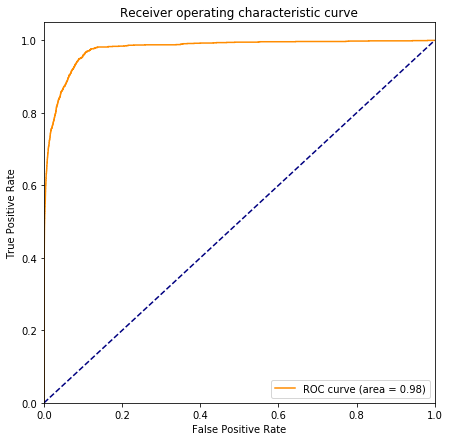

In [45]:
fpr,tpr,threshold = roc_curve(y_test, log.predict_proba(X_test)[:,1]) 
roc_auc = auc(fpr,tpr)
 
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

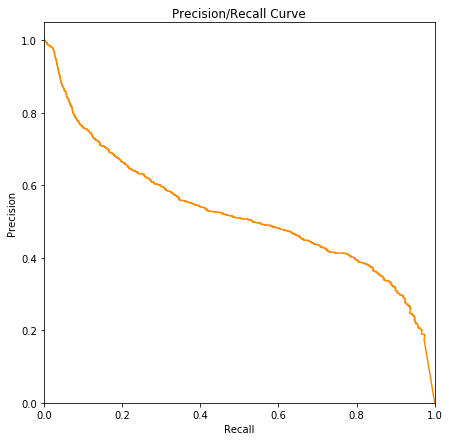

In [46]:
### because the distribution of classes are highly skewed, using pr curve would probably be a better idea.
precision, recall, thresholds = precision_recall_curve(y_test, log.predict_proba(X_test)[:,1])
plt.figure(figsize=(7,7))
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(precision, recall,color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [47]:
import warnings
warnings.filterwarnings("ignore")

In [48]:
#from sklearn.model_selection import GridSearchCV

#log = LogisticRegression()

#c_values = [10, 1, 0.1]
#penalty = ['l2']
#solver = ['sag', 'saga']

#param = dict(solver = solver, penalty = penalty, C = c_values)

#lg_grid = GridSearchCV(estimator=log, param_grid=param, cv=5, scoring='accuracy',error_score=0)
#lg_grid.fit(X_train_os, y_train_os)

In [49]:
#lg_grid.best_params_

In [50]:
#params = {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
#log = LogisticRegression(**params)
#log.fit(X_train_os, y_train_os)
#y_pred = log.predict(X_test)
#print(classification_report(y_test, y_pred))

In [51]:
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier

In [53]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       1.00      0.99      1.00      1646

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



In [54]:
TP, FP, TN, FN = perf_measure(np.array(y_test), y_pred)
precision = TP/(TP+FP)
recall = TP/(TP+FN)

F2_score = (1+2**2)*(precision*recall)/(2**2*precision+recall)
print('F2_score is {}'.format(F2_score))

F2_score is 0.9946465506752648


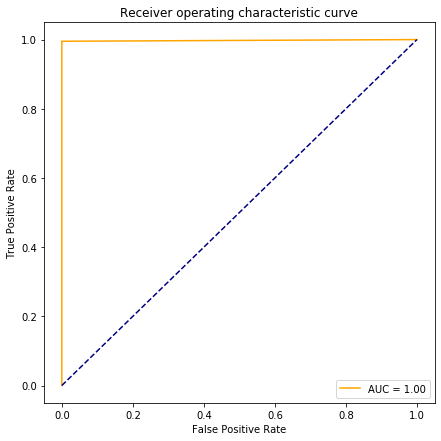

In [55]:
fpr, tpr, threshold = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (7, 7))
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0,1], [0,1], color = 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

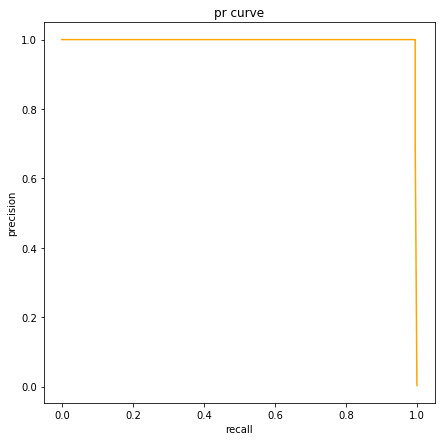

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.figure(figsize = (7, 7))
plt.plot(recall, precision, color = 'orange')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('pr curve')
plt.show()

In [57]:
rf = RandomForestClassifier()
rf.fit(X_train_os, y_train_os)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.98      1.00      0.99      1646

    accuracy                           1.00    554082
   macro avg       0.99      1.00      0.99    554082
weighted avg       1.00      1.00      1.00    554082

